# __APARTADO C__


Antes de empezar vamos a cargar los datos del CSV que nos ha tocado.  
Empezaremos con la carga de las librerias necesarias.

In [599]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D
import math

In [600]:
DATA_DIR = 'data/insurance.csv'

def read_database(dir : str):
    return pd.read_csv(dir, delimiter= ',')

df = read_database(DATA_DIR)
print(df.head(5))
print(df.describe())
print(df.info())

   age     sex   bmi  children smoker     region  expenses
0   19  female  27.9         0    yes  southwest  16884.92
1   18    male  33.8         1     no  southeast   1725.55
2   28    male  33.0         3     no  southeast   4449.46
3   33    male  22.7         0     no  northwest  21984.47
4   32    male  28.9         0     no  northwest   3866.86
               age          bmi     children      expenses
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.665471     1.094918  13270.422414
std      14.049960     6.098382     1.205493  12110.011240
min      18.000000    16.000000     0.000000   1121.870000
25%      27.000000    26.300000     0.000000   4740.287500
50%      39.000000    30.400000     1.000000   9382.030000
75%      51.000000    34.700000     2.000000  16639.915000
max      64.000000    53.100000     5.000000  63770.430000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Colu

Podemos ver que tenemos 2 columnas decimales que es el bmi y los costes. 2 columnas con valores enteros, age y children. Por ultimo tenemos 3 columnas categoricas smoker, region, sex.

Sabiendo esta informacion vamos a ver la cantidad de gente fumadora.

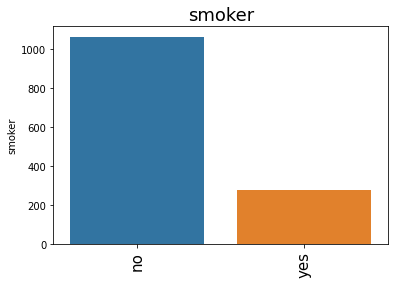

In [601]:
def barplot_gen(df_colum : pd.Series):
    classes = df_colum.value_counts()
    class_len = len(classes)
    sns.barplot(x=np.arange(class_len), y=classes)
    plt.xticks(np.arange(len(classes)), classes.index.values.tolist(), rotation=90, fontsize=15)
    plt.title(df_colum.name, fontsize=18)
    plt.show()

barplot_gen(df['smoker'])

Podemos observar que la cantidad de fumadores en esta base de datos es muy baja, por lo que si queremos realizar una prediccion de esta atributo tendremos problemas para poder realizar un entrenamiento del modelo de red neuronal. Al tratarse en esta practica de utilizar un modelos de regresion lineal y ser valores categoricos, vamos a descartar este valor para realizar la prediccion.

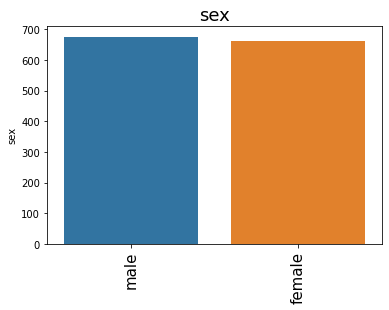

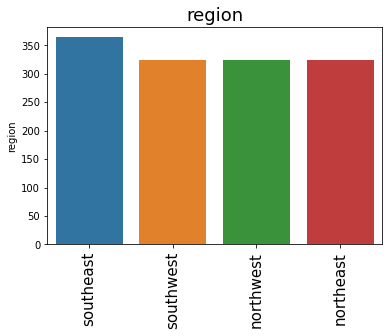

In [602]:
barplot_gen(df['sex'])
barplot_gen(df['region'])

Una vez visto los valores categoricos podemos descartar smoker como a valor a predecir, ya que tenemos pocos datos de valores de fumadores. Pero en cambio si queremos hacer una regresion logistica podemos utilizar sex.

Ahora vamos a ver los valores no categoricos.

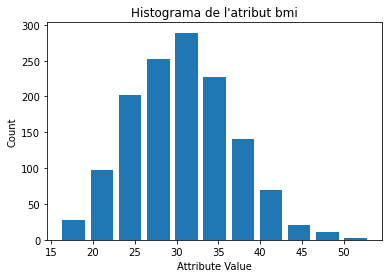

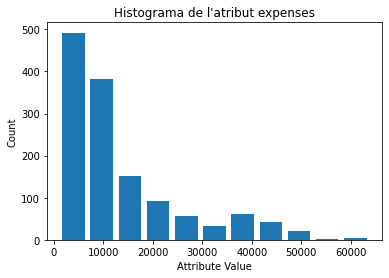

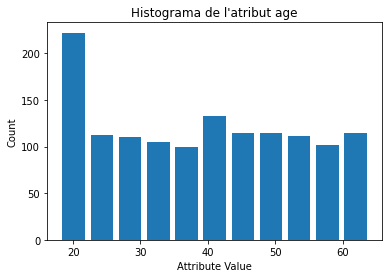

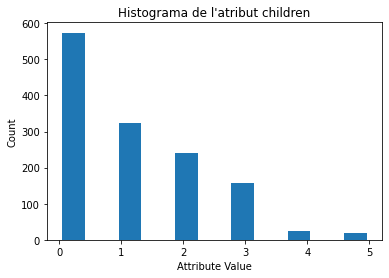

In [603]:
def hist_gen(df_colum : pd.Series):
    plt.figure()
    plt.title(f"Histograma de l'atribut {df_colum.name}")
    plt.xlabel("Attribute Value")
    plt.ylabel("Count")
    plt.hist(df_colum, bins=11, range=[np.min(df_colum), np.max(df_colum)], histtype="bar", rwidth=0.8)

hist_gen(df['bmi'])
hist_gen(df['expenses'])
hist_gen(df['age'])
hist_gen(df['children'])

Podemos observar que hay un atributo que si tiene una distribucion Guassiana, en este caso es el atributo bmi.

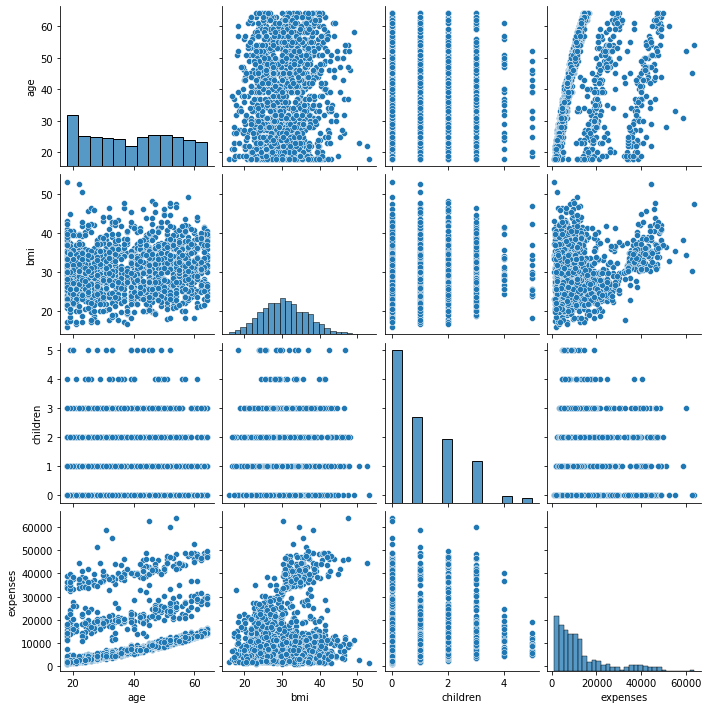

In [604]:
relacio = sns.pairplot(df)

In [605]:
def caregorical_to_onehot_encode(df, col):
    dummy = pd.get_dummies(df[col]) 
    df = df.drop(col, axis = 1) 
    return pd.concat([df, dummy], axis = 1)

def object_to_number(df, column, value):
    df_tmp = df[column].apply(lambda x: 1 if x == value else 0)
    df = df.drop(column, axis = 1) 
    return pd.concat([df, df_tmp], axis = 1)

df = object_to_number(df, 'sex', 'male')
df = object_to_number(df, 'smoker', 'yes')

df = caregorical_to_onehot_encode(df, 'region')

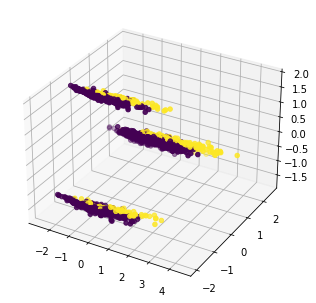

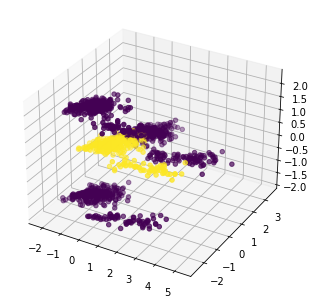

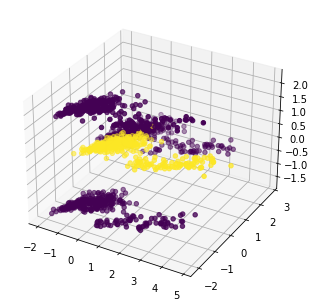

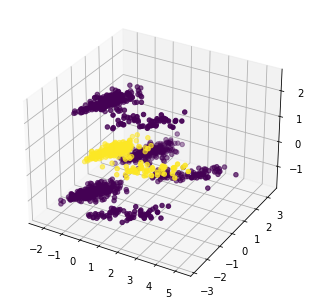

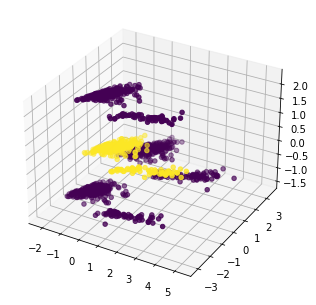

In [606]:
def show_3d_plot(df, column):
    y = df[column].to_numpy()
    X = df.drop([column], axis="columns").to_numpy()
    
    scaler = StandardScaler()
    X_s = scaler.fit_transform(X)

    pca=PCA(n_components=3)
    X_train_3dim = pca.fit_transform(X_s)

    fig = plt.figure()
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    ax.scatter(X_train_3dim[:,0], X_train_3dim[:,1], X_train_3dim[:,2], c=y)

    plt.show()

def show_2d_plot(df, column):
    y = df[column].to_numpy()
    X = df.drop([column], axis="columns").to_numpy()
    
    scaler = StandardScaler()
    X_s = scaler.fit_transform(X)
    
    pca=PCA(n_components=2)
    X_train_3dim = pca.fit_transform(X_s)

    plt.scatter(X_train_3dim[:,0],X_train_3dim[:,1], c=y)
    plt.show()

show_3d_plot(df, 'smoker')

show_3d_plot(df, 'southwest')
show_3d_plot(df, 'southeast')
show_3d_plot(df, 'northwest')
show_3d_plot(df, 'northeast')

__1. Quin és el tipus de cada atribut?__  

0.   age  int64
1.   sex  object
2.   bmi  float64
3.   children int64 
4.   smoker  object
5.   region object
6.   expenses float64


__2. Quins atributs tenen una distribució Gaussiana?__  

BMI  

__3. Quin és l'atribut objectiu? Per què?__

Leyendo el extracto de Kaggle y entendiendo el objetivo de la empresa, el cual es otorgar Seguros Médicos. Podemos llegar a suponer que la variable objetivo es la de "expenses", debido a que esta expresa el gasto que tiene cada persona según su actual situación.

# __APARTADO B__


In [607]:
def mse(v1, v2):
    return ((v1 - v2)**2).mean()

def regression(x, y):
    # Creem un objecte de regressió de sklearn
    regr = LinearRegression()

    # Entrenem el model per a predir y a partir de x
    regr.fit(x, y)

    # Retornem el model entrenat
    return regr

def standarize(x_train):
    mean = x_train.mean(0)
    std = x_train.std(0)
    x_t = x_train - mean[None, :]
    x_t /= std[None, :]
    return x_t

def split_data(x, y, train_ratio=0.8):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    n_train = int(np.floor(x.shape[0]*train_ratio))
    indices_train = indices[:n_train]
    indices_test = indices[n_train:] 
    x_train = x[indices_train, :]
    y_train = y[indices_train]
    x_test = x[indices_test, :]
    y_test = y[indices_test]
    return x_train, y_train, x_test, y_test

In [608]:
y = df['smoker'].to_numpy().astype('int')
x = df.drop(['smoker'], axis="columns").to_numpy()

# Dividim dades d'entrenament
x_train, y_train, x_test, y_test = split_data(x, y)

stndScal = StandardScaler()

x_train = stndScal.fit_transform(x_train)
x_test = stndScal.transform(x_test)

error_np = np.zeros(x_train.shape[1])

for i in range(x_train.shape[1]):
    x_t = x_train[:,i] # seleccionem atribut i en conjunt de train
    x_v = x_test[:,i] # seleccionem atribut i en conjunt de val.
    x_t = np.reshape(x_t,(x_t.shape[0],1))
    x_v = np.reshape(x_v,(x_v.shape[0],1))

    regr = regression(x_t, y_train)    
    error = mse(y_test, regr.predict(x_v)) # calculem error
    error_np[i] = error
    r2 = r2_score(y_test, regr.predict(x_v))

    print("Error en atribut %d: %f" %(i, error))
    print("R2 score en atribut %d: %f" %(i, r2))



Error en atribut 0: 0.148072
R2 score en atribut 0: -0.007116
Error en atribut 1: 0.148171
R2 score en atribut 1: -0.007786
Error en atribut 2: 0.148036
R2 score en atribut 2: -0.006868
Error en atribut 3: 0.048425
R2 score en atribut 3: 0.670634
Error en atribut 4: 0.147923
R2 score en atribut 4: -0.006100
Error en atribut 5: 0.148289
R2 score en atribut 5: -0.008590
Error en atribut 6: 0.148071
R2 score en atribut 6: -0.007106
Error en atribut 7: 0.146394
R2 score en atribut 7: 0.004300
Error en atribut 8: 0.147631
R2 score en atribut 8: -0.004117


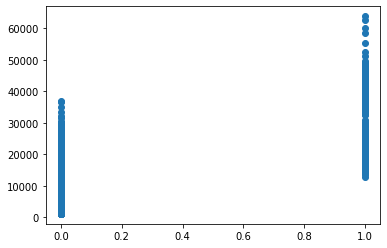

In [609]:
ax = plt.scatter(y, x[:,3])

Així es podrà contestar a aquestes **preguntes**:

__1. Quin són els atributs més importants per fer una bona predicció?__

Amb l'atribut 3, el qual representa les "expenses".

__2. Amb quin atribut s'assoleix un MSE menor?__

Al igual que amb el punt anterior la dada que assoleix un MSE menor torna a ser les "expenses".

__3. Quina correlació hi ha entre els atributs de la vostra base de dades?__


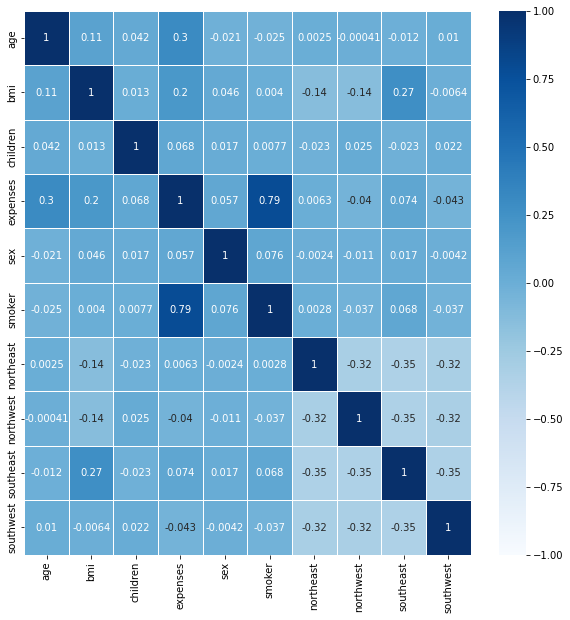

In [610]:
correlacio = df.corr()
plt.figure(figsize=(10, 10))
ax = sns.heatmap(correlacio, annot=True, vmin=-1, linewidths=.5, cmap=plt.cm.Blues)

__4. Com influeix la normalització en la regressió?__

Al aplicar o no la normalització amb el codi de regressió per cada atribut, no veiem cap tipus de diferencia notable. Es pot veure representat a les dades que obtenim, el cual un grup de dades es normalitzat i l'altre no:

Normalitzat

    Error en atribut 0: 0.150293
    R2 score en atribut 0: -0.005932
    Error en atribut 1: 0.150548
    R2 score en atribut 1: -0.007636
    Error en atribut 2: 0.152524
    R2 score en atribut 2: -0.020866
    Error en atribut 3: 0.046985
    R2 score en atribut 3: 0.685521

No Normalitzat

    Error en atribut 0: 0.152679
    R2 score en atribut 0: -0.006059
    Error en atribut 1: 0.152483
    R2 score en atribut 1: -0.004767
    Error en atribut 2: 0.152404
    R2 score en atribut 2: -0.004244
    Error en atribut 3: 0.053519
    R2 score en atribut 3: 0.647343


__5. Com millora la regressió quan es filtren aquells atributs de les mostres que no contenen informació?__

L'error R2 millora molt, ja que només utilitzem els atributs que superen un desitjat threshold, com per exemple "expenses", que ens dona un R2 superior a 0.5.

In [611]:
y = df['smoker'].to_numpy().astype('int')
x = df.drop(['smoker'], axis="columns").to_numpy()

# Dividim dades d'entrenament
x_train, y_train, x_test, y_test = split_data(x, y)

stndScal = StandardScaler()

x_train = stndScal.fit_transform(x_train)
x_test = stndScal.transform(x_test)

regr = regression(np.reshape(x_train[:,3],(x_train[:,3].shape[0],1)), y_train)    
error = mse(y_test, regr.predict(np.reshape(x_test[:,3],(x_test[:,3].shape[0],1)))) # calculem error
r2 = r2_score(y_test, regr.predict(np.reshape(x_test[:,3],(x_test[:,3].shape[0],1))))

print("Error: ", error, " R2: ", r2)

Error:  0.06174984823908961  R2:  0.6358685468042387


__6. Si s'aplica un PCA, a quants components es redueix l'espai? Per què?__

Es redueix a tants com es refereixi al parametre n_components de PCA(). Però també podem trobar variables que podem assignar al parametre n_components, com per exemple 'mle', el qual destria els atributs més significatius.

In [612]:
y = df['smoker'].to_numpy()
X = df.drop(['smoker'], axis="columns").to_numpy()

scaler = StandardScaler()
X_s = scaler.fit_transform(X)

pca=PCA(n_components='mle', svd_solver='full')
X_train_3dim = pca.fit_transform(X_s)

print("X_train_3dim: ", X_train_3dim, "\nShape: ", X_train_3dim.shape)

X_train_3dim:  [[-0.81081428 -1.53886499 -1.23724483 ... -0.38666892  0.39110001
   1.50604517]
 [ 0.92021416 -0.37033551  0.66905435 ...  0.10405916  0.0504959
  -0.04257256]
 [ 1.1893255  -0.28948873  0.58803844 ...  1.46483116 -0.33261574
  -0.36048131]
 ...
 [ 0.97648943 -0.41110438  0.68257402 ...  0.11022504  0.75305888
   0.10503368]
 [-1.42611441 -1.74628438 -1.17179888 ... -0.24960797  0.04878289
   0.61245733]
 [-0.06721373  0.20507518  1.41216893 ... -0.9945901  -0.22662597
   0.29937024]] 
Shape:  (1338, 8)


In [618]:
y = df['smoker'].to_numpy().astype('int')
X = df.drop(['smoker'], axis="columns").to_numpy()

scaler = StandardScaler()
X_s = scaler.fit_transform(X)

# PCA no presenta variabilitat al resultat
pca=PCA(n_components='mle', svd_solver='full')
X_train_3dim = pca.fit_transform(X_s)

# Dividim dades d'entrenament
x_train, y_train, x_test, y_test = split_data(X_s, y)

regr = regression(x_train, y_train)    
error = mse(y_test, regr.predict(x_test)) # calculem error
r2 = r2_score(y_test, regr.predict(x_test))


print("error: ", error, "\nR2: ", r2, "\nx3: ", X_train_3dim.shape)

error:  0.04236634390106556 
R2:  0.7290847325186847 
x3:  (1338, 8)
